In [1]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits

# Grizli
import grizli
from grizli.model import GrismFLT
import pysynphot as S

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits")
root = "GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits" # Change filename with this variable
direct_file = "ready_direct_{0}".format(root)
seg_file = "seg_{0}".format(root)
cat_file = "cat_{0}.detect.cat".format(root)

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
pad=100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation seg_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [3]:
# Read in Table, prepare variables for dispersion
tbl = Table.read(cat_file, format="ascii.ecsv")
nans = []
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"

# Disperse one object at a time, store disperion on original image
for ii, object in enumerate(tbl):
    
    # Pull variables from tbl
    id = object["id"]
    mag = object["mag"]
    sed = object["SED"]
    z = object['z']

    # Pull Flux and Lambda from file
    sed_path = os.path.join(SED_dir, sed)
    spectrum = Table.read(sed_path, format="fits")
    rest_wave = spectrum["wavelength"]
    flux = spectrum["flux"]

    # Redshift Spectrum
    # z = (10000 / rest_wave.min()) - 1
    redshifted_wave = rest_wave * (z+1)

    # Compute pysynphot Spectrum
    spec = S.ArraySpectrum(wave=redshifted_wave, flux=flux)

    roman_sim.compute_model_orders(id, mag=mag, compute_size=False, size=77, 
                                   in_place=True, store=False, spectrum_1d=[spec.wave, spec.flux])

    # Check for nans, print object ; set nans to zero (otherwise, endless printing)
    if np.any(np.isnan(roman_sim.model)):
        nans.append({"id": id, "sed": sed})
        roman_sim.model = np.where(np.isnan(roman_sim.model), 0, roman_sim.model)

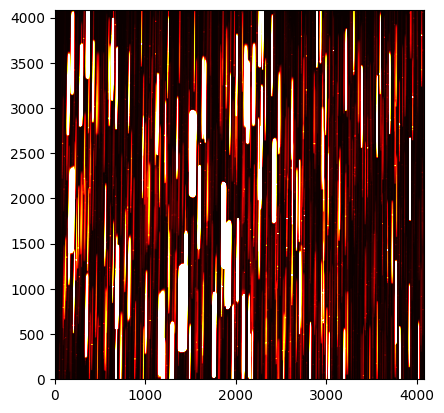

In [4]:
upright_img = np.rot90(roman_sim.model[pad:-pad, pad:-pad])
plt.imshow(upright_img, cmap='hot', origin='lower', vmin=0.001, vmax=roman_sim.model.max()/1000)

In [5]:
raise Exception("Pause before saving")

Exception: Pause before saving

In [ ]:
# Primary HDU is opened and closed above. Comment out direct_fits.close() if you plan to save here.
file = fits.open(direct_file)
header = file[1].header
PrimaryHDU = file[0]

ImageHDU = fits.ImageHDU(data=upright_img, header=header, name='SCI')
err_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name='ERR')
DQ_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name='DQ')

hdul = [PrimaryHDU, ImageHDU, err_HDU, DQ_HDU]

fits.HDUList(hdul).writeto("proper_spectra_{0}".format(root), overwrite=True)

file.close()